# 3D Shapes and Trimesh

[Trimesh](https://trimesh.org/) is a well-known and well-maintained library for
working with 3D geometry.

The goal of Trimesh is to "provide a full featured and well tested Trimesh
object which allows for easy manipulation and analysis, in the style of the
Polygon object in the Shapely library."

Trimesh can greatly extend py5's ability to load 3D objects, far exceeding what
can be achieved with [](/reference/sketch_load_shape.md).

## Setup

Installing Trimesh by itself is acceptable but Trimesh is much more useful if
you install its dependent libraries. At a minimum, you should install the easy
to install dependencies with this command:

```bash
pip install trimesh[easy]
```

Refer to the [Trimesh Installation page](https://trimesh.org/install.html) for
more information about Trimesh's dependencies and installation options.

Development of py5's integration code was done with Trimesh version 3.23.
Version 4.0 was released shortly after but seems to work just as well as 3.23.

Installing [OpenSCAD](https://openscad.org/) or
[Blender](https://www.blender.org/) on your computer may also be useful. Trimesh
can use these to perform boolean operations on 3D objects.

If Trimesh is missing a dependent library needed for the functionality you want
to use, it will provide you with an error message informing you of what you
should install.

## Convert Trimesh objects to Py5Shapely objects

Let's start by importing the trimesh library and some classes we will use later.

In [30]:
import py5_tools
import py5

import trimesh

For our first example, we will use a 3D model file downloaded from
[TurboSquid](https://www.turbosquid.com/). Our example is a
[strawberry](https://www.turbosquid.com/3d-models/3d-strawberry-1962030)
created by the artist [minimoku](https://www.turbosquid.com/Search/Artists/minimoku).

Loading a complex 3D model in trimesh may be slow. Don't load a model from within a
Sketch unless absolutely necessary.

In [2]:
strawberry_model = trimesh.load('models/Strawberry_gltf.gltf')

We can use the [`convert_shape()`](/reference/sketch_convert_shape) method to effortlessly
convert this model into a `Py5Shape` object.

In [32]:
def setup():
    global strawberry
    py5.size(300, 500, py5.P3D)
    strawberry = py5.convert_shape(strawberry_model)
    assert isinstance(strawberry, py5.Py5Shape)

Now let's create a `draw()` method to draw the `Py5Shape` object with the
[`shape()`](/reference/sketch_shape) method. In this example, 

In [33]:
y_rot = 0


def draw():
    global y_rot
    y_rot += 1

    py5.background(255)
    py5.ambient_light(32, 32, 32)

    py5.translate(200, 400, 0)

    # invert the model's y axis and increase the scale
    py5.scale(1, -1, 1)    
    py5.scale(50)

    py5.rotate_z(py5.radians(105))
    py5.rotate_y(py5.radians(-15))
    py5.directional_light(220, 220, 220, 0, -1, 1)
    py5.rotate_x(py5.radians(y_rot))

    py5.shape(strawberry, 0, 0)

We need to invert the model's y axis because the top of the strawberry is oriented towards
the positive y axis but Processing and therefore py5 has the positive y axis pointing
towards the bottom of the drawing surface. You will frequently need to employ rotations
and scale adjustments when working with models created outside of py5.

When we run this, the strawberry will slowly rotate along its main axis.

In [34]:
py5.run_sketch()

The result looks like this:

Output(layout=Layout(max_height='200px', overflow='auto'))

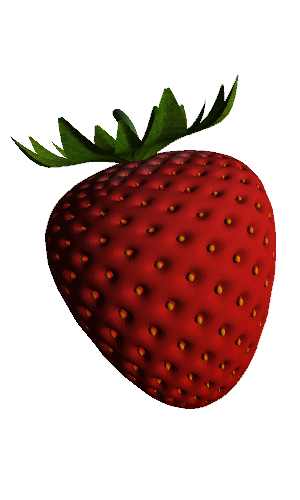

In [35]:
py5_tools.screenshot()

Neat, huh? 

The [`convert_shape()`](/reference/sketch_convert_shape) method did all the heavy lifting to create
the mesh and add the texture.

Note that this particular model also has additional texture information for XXXX and YYYY. Since the
default py5 polygon shader cannot make use of these, py5's
[`convert_shape()`](/reference/sketch_convert_shape) method will not add them to the created
`Py5Shape` object.

Simple geometry examples, show boolean operations

Include note about colors, may need to disable style. Sometimes trimesh adds a
style to something. If the object has a style, py5 (should) pick up on that and
use it.

Scene, Trimesh, Path2D, Path3D

## Options

textures